In [21]:
'''This salary prediction model pulls job data and predicts salaries across multiple models. 
    It then saves the model and produces a prediction file.'''

In [ ]:
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

### Import packages

In [1]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import pickle
import os

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Defining Data class

In [6]:
class Data:
    def __init__(self, train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target):
        '''create train and test dataframes'''
        self.col_cat = col_cat
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.col_id = col_id
        self.col_target = col_target
        self.train_df_eda = self._create_train_eda(train_file, train_target_file)
        self.test_df_eda = self._create_test_eda(test_file)
        self.train_df = self._create_train_df(train_file, train_target_file)
#         self.train_df = self._shuffle_data(self.train_df) # KEEP
        self.test_df = self._create_test_df(test_file)
        
    def _create_train_df(self, train_feature_df, train_target_df):
        '''create train dataframe'''
        train_target = self._load_file(train_target_df)
        train_df = self._load_file(train_feature_df)
        train_df = self._join_df(train_df, train_target, col_id)
        train_df = self._clean_data(train_df)
        train_df = self._label_encode(train_df, self.col_cat)
        return train_df
    
    def _create_train_eda(self, train_feature_df, train_target_df):
        '''create train dataframe for feature engineering'''
        train_target = self._load_file(train_target_df)
        train_df = self._load_file(train_feature_df)
        train_df = self._join_df(train_df, train_target, col_id)
        train_df = self._clean_data(train_df)
        return train_df
    
    def _create_test_eda(self, test_feature_df):
        '''create test dataframe for feature engineering'''
        test_df = self._load_file(test_feature_df)
        return test_df
    
    def _create_test_df(self, test_file):
        '''create test dataframe'''
        test_df = self._load_file(test_file)
        test_df = self._label_encode(test_df, col_cat)
        return test_df

    def _shuffle_data(self, train_df):
        '''shuffling data'''
        return shuffle(train_df).reset_index()

    def _clean_data(self, df):
        '''remove outliers from data'''
        train_df = df
        train_df = train_df[(train_df.salary > 8) & (train_df.salary < 220)]
        return train_df
    
    def _label_encode(self, df, col_cat):
        '''label encode dataframes'''
        le = LabelEncoder()
        for col in col_cat:
            df[col] = le.fit_transform(df[col])
        return df
         
    def _join_df(self, train_df, train_target, col_id):
        '''join train and target dataframes'''
        return pd.merge(train_df, train_target, on=col_id, how='inner')

    def _load_file(self, file):
        '''load files'''
        return pd.read_csv(file)

### Defining Feature Engineering class

In [7]:
class FeatureEngineering:
    def __init__(self, train_df_eda, train_df, test_df_eda, test_df, col_cat, target, col_id):
        '''create train and test dataframes'''
        df_temp = pd.DataFrame()
        self.train_df = train_df
        self.train_df_eda = train_df_eda
        self.test_df = test_df
        self.test_df_eda = test_df_eda
        self._groupby(self.train_df_eda, train_df, self.test_df_eda, col_cat, target)
    
    def _groupby(self, train_df_eda, train_df, test_df_eda, col_cat, col_target):
        '''parse through each categorical column and compute mean of each unique value'''
        for i in range(0, len(col_cat)):
            df_temp = self._compute_mean(train_df_eda, col_cat, i, col_target)
            list_col_temp = df_temp[col_cat[i]]
            list_col_target = df_temp[col_target]
            dict_temp = self._create_dictionary(df_temp, list_col_temp, list_col_target)
            data.train_df[col_cat[i] +'_mean'] = self._map_dictionary(train_df_eda, col_cat, i, dict_temp)
            data.test_df[col_cat[i] +'_mean'] = self._map_dictionary(test_df_eda, col_cat, i, dict_temp)
            self._append_columns(train_df, col_cat, i)
        data.col_all = data.col_cat + data.col_num
    
    def _compute_mean(self, train_df_eda, col_cat, i, col_target):
        '''compute mean of unique categorical values'''
        return train_df_eda.groupby(col_cat[i])[col_target].mean().sort_values(ascending=True).reset_index()
        
    def _create_dictionary(self, df_temp, list_col_temp, list_col_target):
        '''create dictionary of unique categorical values and mean salary values'''
        dict_temp ={}
        for j in range(0,len(df_temp)):
            dict_temp.update([(list_col_temp[j], list_col_target[j])]) 
        return dict_temp
    
    def _map_dictionary(self, df_eda, col_cat, i, dict_temp):
        '''mapping dictionary values'''
        return df_eda[col_cat[i]].map(dict_temp)
    
    def _append_columns(self, train_df, col_cat, i):
        '''appending new column names to col_num list'''
        data.col_num.append(train_df[col_cat[i] +'_mean'].name)

### Defining Model class

In [8]:
class Model:
    def __init__(self, train_features, train_target, model_container, set_cv, num_proc, dir_pred):
        '''create train dataframe'''
        self.train_features = train_features
        self.train_target = train_target
        self.filename = 'best_model.sav'
    
    def add_model(self, model):
        '''add new models'''
        model_container[model] = self._score_model(model, self.train_features, self.train_target, set_cv, num_proc)
    
    def fit_model(self, model, train_df, train_target):
        '''fit model'''
        return model.fit(train_df, train_target)
        
    def predict_model(self, model_selected, test_df, train_df, train_target):
        '''predict and store best model'''
        model = self.fit_model(model_selected, train_df, train_target)
        self._save_model(model,self.filename)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        df_feat = self._important_features(model)
        self._feature_barplot(df_feat)
        return prediction_results
    
    def _important_features(self,model):
        '''create feature importance dataframe'''
        col_feat_rank = pd.DataFrame(model.feature_importances_, columns=['score'])
        col_feat = pd.DataFrame(data.col_all, columns=['feature'])
        df_feat = pd.concat([col_feat,col_feat_rank],axis=1).sort_values('score',ascending=False).reset_index(drop=True)
        print("\nFeature Importances\n", df_feat)
        return df_feat

    def _feature_barplot(self, df):
        '''create feature importance barplot'''
        sns.barplot(df.score,df.feature, palette='Blues_d').set_title('Feature Importances')
        
    def best_scoring_model(self, model_container):
        '''select best scoring model'''
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._print_summary(best_model, best_score)
        return best_model
    
    def _print_summary(self, best_model, best_score):
        '''print summary results of best model'''
        print('\nThe best model is:\n', best_model)
        print('\nThe best score is:\n', best_score)
        
    def load_model(self, load_best_model):
        '''load best model '''
        if load_best_model:
            loading_best_model = joblib.load(self.filename)
        return loading_best_model

    def _save_model(self, model, filename):
        '''save best model'''
        pickle.dump(model, open(filename, 'wb'))
        
    def _score_model(self, model, train_df, target_train, set_cv, num_proc):
        '''score model'''
        return -1.0*np.mean(cross_val_score(model, train_df, target_train, scoring='neg_mean_squared_error', cv=set_cv, n_jobs=num_proc))

    def _save_prediction(self, prediction_results):
        '''save predictions as csv file'''
        prediction_results = pd.DataFrame(prediction_results).to_csv(dir_pred)

### Defining parameters to run model

In [23]:
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
train_target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

set_cv = 2
num_proc = -1
load_best_model = True
dir_pred = '/Users/krahman/work/salarypredictionportfolio/predictions/test_salaries.csv'
model_container = {}

In [24]:
train_features = data.train_df[data.col_all]
train_target = data.train_df[col_target]
test_features = data.test_df[data.col_all]

##
train_features = data.train_df.loc[:1000,:]
train_target = data.train_df.loc[:1000,:]
test_features = data.test_df.loc[:1000,:]
train_features = train_features[data.col_all]
train_target = train_target[col_target]
test_features = test_features[data.col_all]
###

### Create data object

In [ ]:
data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)

### Create feature engineering object

In [ ]:
fe = FeatureEngineering(data.train_df_eda, data.train_df, data.test_df_eda, data.test_df, data.col_cat, data.col_target, col_id)

### Create model object

In [15]:
model = Model(train_features, train_target, model_container, set_cv, num_proc, dir_pred)

### Add models, score, select best model, create prediction file and print summary


The best model is:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The best score is:
 537.9757770986146

Feature Importances
                 feature     score
0          jobType_mean  0.293871
1       yearsExperience  0.168254
2   milesFromMetropolis  0.149785
3         industry_mean  0.097212
4           degree_mean  0.066918
5               jobType  0.065958
6            major_mean  0.052197
7

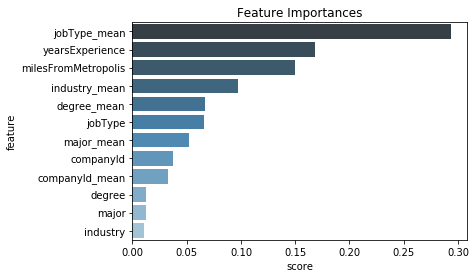

In [30]:
model.add_model(GradientBoostingRegressor(loss='ls', n_estimators=500, max_depth=5))
# model.add_model(LinearRegression())
selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features, train_features, train_target)

import time
start_time = time.time()
elapsed_time = time.time() - start_time
print('\nTime elapsed:',elapsed_time/60)

# model_temp = model.load_model(load_best_model)
# model_temp.predict(test_features)

In [19]:
# 0. Add feature importance.
# 0.1 check on rounding off errors
# 1. Make presentable
# 2. Clean up Eda
# 3. Comment EDA
# 4. Make EDA presentable 

2459.822257757187/60

40.997037629286446

In [31]:
pred_result
# np.around(pred_result, decimals=0)

array([120.77827359,  87.64457742, 167.41032115, ...,  60.82360645,
       114.48536137, 123.2298568 ])

In [ ]:
# NEXT, clean up our code, train and test entire model, fix output to round off? 

# import time
# start_time = time.time()
# elapsed_time = time.time() - start_time
# print(elapsed_time) 

# # TESTING BY INDUSTRY 
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import time

# # before we score it, we need to predict, then inverse transform
# def scoring_gbr_gs():
#     score_total = 0
#     loss_types = ['ls', 'lad', 'huber', 'quantile']
#     learning_rate = [.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]
#     alpha= [.001,.01,.1,.2,.3,.4,.5,.6,s.7,.8,.9,.95]
#     n_estimators = [100,200,300,400,600,1000,2000]
#     subsample =[1,.9,.8,.7,.6,.5,.4,.3,.2,.1]
#     max_depth = [1,2,3,4,5,6,7,8,9,10]
#     model_gbr = GradientBoostingRegressor()
#     param_grid = dict(
#                      loss=['ls'],
#                      learning_rate=[.1],
#                       alpha=[.1],
#                       n_estimators=[180],
#                      subsample=[1],
#                      max_depth=[4]
#                      )
#     random = RandomizedSearchCV(estimator=model_gbr,
#                                 param_distributions=param_grid,
#                                 scoring='neg_mean_squared_error',
#                                 n_jobs=-1,
#                                 cv=5)
    
# #     for val in ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']:
#     df = data.train_df
#     train_temp = df[df['industry']=='HEALTH']
#     y_train_temp = train_temp.pop('salary')
#     train_temp = train_temp.drop(['industry'],axis=1)

# #     train_temp = train_temp.drop(['jobType', 'degree', 'major', 'industry'],axis=1)

#     random_fit = random.fit(train_temp,y_train_temp)
#     scores = random_fit.best_score_
#     print(scores)
#     score_total = score_total + scores
#     print(random_fit.best_params_)
        
# #     score_avg = score_total/7
# #     print('Average score')
# #     print(score_avg)
#     return scores

# start_time = time.time()
# scores = scoring_gbr_gs()
# elapsed_time = time.time() - start_time
# print(elapsed_time) 

In [32]:
class Heatmap:
    def __init__(self, train_df, target, title):
        '''initializes class and concatenates train_df and target variables'''
        self.df = self._concat_df(train_df, target)
        self.col = df.columns
        self.target = target.name
        self.heatmap = self._create_corr_df(self.df, self.col, self.target, title)
        
    def _concat_df(self, train_df, target):
        '''concatenates training dataframe and target variable''' 
        return pd.concat([train_target, train_features],axis=1)
    
    def _create_corr_df(self, df, col, target, title):
        '''creates correlation matrix from train_df'''
        corr = df.corr().sort_values(target, ascending=False)
        print(corr[target])
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        plt.figure(figsize=(13,11))
        return sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='Blues', annot=True)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)
    
Heatmap(train_features, train_target, 'Heatmap of Correlation Matrix');

NameError: name 'df' is not defined

In [457]:
class Boxplot:
    def __init__(self, train_df, target, var, title):
        self.df = train_df
        self._create_subplot()
        col_avgs = self._calc_averages(df, target.name, var)
        self._create_boxplot(df, var, target, col_avgs)
        self._set_title(title)
        
    def _create_subplot(self):
        plt.subplots(figsize=(12,6.5))
        
    def _calc_averages(self, df, target, var):
        temp_df = df[[var, target]].groupby(var).mean().sort_values(target, ascending=True).reset_index()
        return temp_df[var].values

    def _create_boxplot(self, df, var, target, col_avgs):
        sns.boxplot(var, target.name, data=df, width=.3, color='#eeefff', order=col_avgs)
    
    def _set_title(self, title):
        plt.title(title)

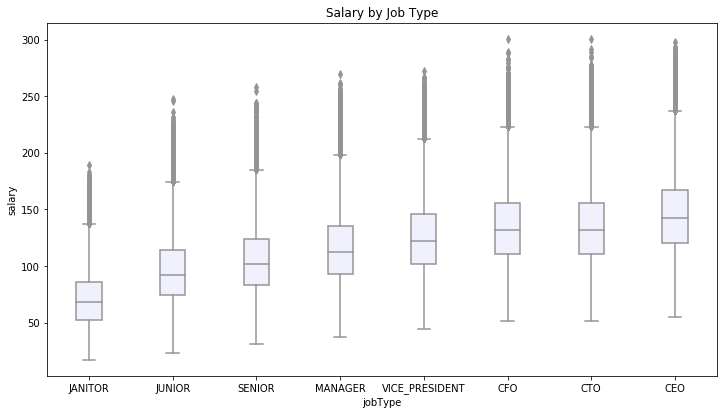

In [458]:
Boxplot(data.train_df_eda, train_target, 'jobType', 'Salary by Job Type');

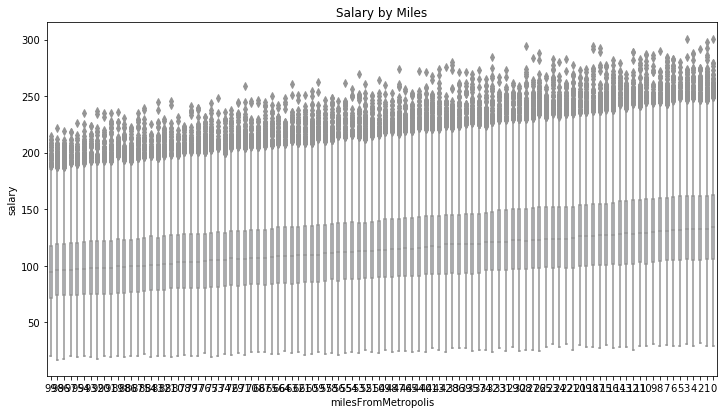

In [480]:
Boxplot(data.train_df_eda, train_target, 'milesFromMetropolis', 'Salary by Miles');

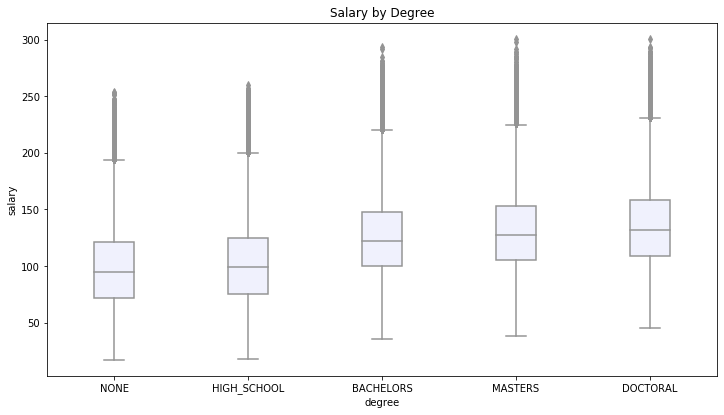

In [459]:
Boxplot(data.train_df_eda, train_target, 'degree', 'Salary by Degree');

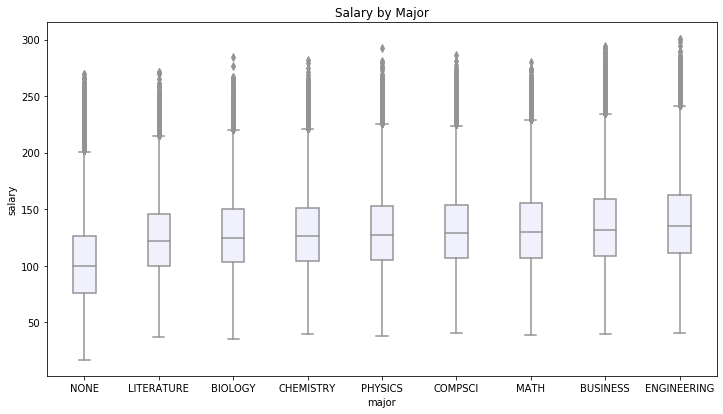

In [460]:
Boxplot(data.train_df_eda, train_target, 'major', 'Salary by Major');

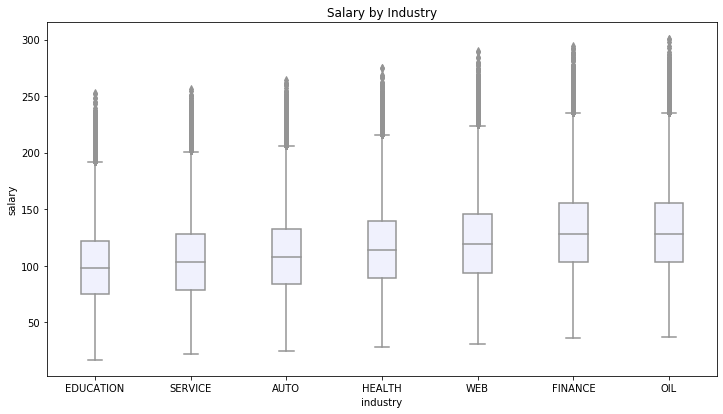

In [553]:
Boxplot(data.train_df_eda, train_target, 'industry', 'Salary by Industry');

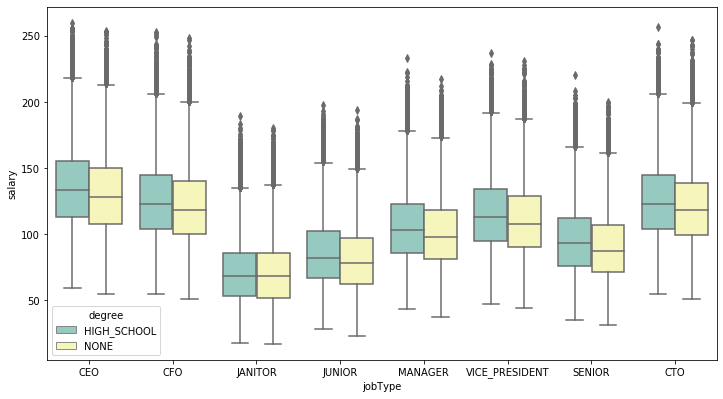

In [481]:
# clean this code
class EDA:
    def __init__(self, data):
        self.data = data
        df = data.train_df_eda
        target = data.train_df_eda.salary
        
    def boxplot(self, col1, var1, var2, col3):
        df = data.train_df_eda
        target = data.train_df_eda.salary
        df = df[(df[col1]==var1) | (df[col1]==var2)]
        f, ax = plt.subplots(figsize=(12,6.5))
        sns.boxplot(x=col3, y=target, hue=col1, data=df, palette='Set3')
        return

eda = EDA(data)
eda.boxplot('degree', 'HIGH_SCHOOL', 'NONE', 'jobType')

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset